# Purpose of Experiment and Introduction

This experiment is the implementation of Deepayan Das's "Adapting OCR with limited supervision" framework, as highlighted in the GitHub repository [Adapting-OCR](https://github.com/Deepayan137/Adapting-OCR), adapted to function with Francesco Pettini's License Plate Characters dataset, available on [Kaggle](https://www.kaggle.com/datasets/francescopettini/license-plate-characters-detection-ocr).

The objective of this endeavor is to tackle any challenges that might emerge from switching over to a new and data source, derived from real-world instances, as opposed to a synthetic dataset. Additionally, the goal is to document and benchmark the performance resulted from this adaptation.


In [1]:
import os
import sys
import pdb
import six
import random
import lmdb
from PIL import Image
import numpy as np
import math
from collections import OrderedDict
from itertools import chain
import logging
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import sampler
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import random_split

from src.utils.utils import AverageMeter, Eval, OCRLabelConverter
from src.utils.utils import EarlyStopping, gmkdir
from src.optim.optimizer import STLR
from src.utils.utils import gaussian
from tqdm import *

Data quality assurance purposes I began by creating a function which restores and displays the images loaded in the dataset by undoing the transformations done upon it (which are hardcoded but can be easilly changed selectively)

In [2]:
from matplotlib import pyplot as plt

# Helper function that I use to check if the images and labels are correctly loaded into the dataset class
def imshow(img, title=None):
    # Converting from Torch tensor to numpy array
    img = img.numpy().transpose((1, 2, 0))
    # Undoing normalization
    mean = 0.5
    std = 0.5
    img = std * img + mean
    img = img.clip(0, 1)  # Clip values to be between 0 and 1
    plt.imshow(img, cmap='gray' if len(img.shape)==2 else None)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pausing to update the plots

The first major revision I have brought to the code was modifying the collator to simplify it and implement the resizing/padding of images based on the maximum size in the dataset (which became redundant as I implemented it directly in the SynthDataset class).

As I would later find out, some images in the dataset had large sizes, which meant that all the images loaded into the model had such large sizes. This led to significant problems with the GPU memory, as I was unable to properly run the model as it would simply run out of VRAM. 

At first I would try my best to improve the model's memory performance (consolidating variables into a single one, running memory profiling on various blocks of code, traces of which are still present in my code). After exhausting all possible solutions, thanks to the profiling, I have noticed that my dataset occupied a significant amount of memory, thus prompting me to discover my error.

I can thus say that I am keeping the image resizer here as a reminder of my error, even if I can safely remove it entirely.

In [3]:
import torchvision.transforms.functional as TF

class SynthCollator(object):
    def __call__(self, batch):
        max_height = max(item['img'].shape[1] for item in batch)
        max_width = max(item['img'].shape[2] for item in batch)
        
        # Resizing all images based on the maximum dimensions in the data (redundant due to SynthDataset operation)
        imgs = [TF.resize(item['img'], (max_height, max_width)) for item in batch]
        
        imgs = torch.stack(imgs, 0)
        
        indexes = [item['idx'] for item in batch]
        
        item = {'img': imgs, 'idx': indexes}
        
        if 'label' in batch[0].keys():
            labels = [item['label'] for item in batch]
            item['label'] = labels
        
        return item


The next step was to create a proper dataset class for the new data. 

This involved changing the path for where the code has to look for the images, that was simple enough, but afterwards I had to extract the labels as well. Because in the original experiment, the labels were the image file names, it was straight forward there, but in my case, I had to extract the characters from the .XML files associated to each image, once extracted, the characters are appended together and used as a label.

Next, the data is split into a training and testing set, as due to the significantly lower size of the dataset (only 209 images), there cannot be a sepparate validation and testing set. The split is done through the use of Python's in-built "random" library which shuffles the list of images and splits 80% of them into a training set and 20% of them into a testing set.

Ultimately, transformations are performed onto the data, namely resizing the images to a hardcoded 100 pixels height by 200 pixels width, the reasoning for this exact dimension is that some images are exceedingly large.

In [4]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import random
from PIL import Image
import xml.etree.ElementTree as ET

class SynthDataset(Dataset):
    def __init__(self, opt, train=True):
        super(SynthDataset, self).__init__()
        
        # Loading images
        self.img_dir = os.path.join(opt['path'], opt['imgdir'])
        
        # Loading annotations
        self.anno_dir = os.path.join(opt['path'], 'annotations')
        
        self.images = os.listdir(self.img_dir)
        
        # Train-Test splitting procedure
        
        random.seed(42)  # Setting seed for reproducibility
        random.shuffle(self.images)  # Shuffling the list of images
        self.train = train  # Flag to indicate if this is training or testing dataset
        
        # Splitting data into training and testing sets
        split_idx = int(0.8 * len(self.images))  # 80% for training
        train_images, test_images = self.images[:split_idx], self.images[split_idx:]
        
        # Using training data if train flag is True, else using testing data
        self.images = train_images if self.train else test_images
        self.nSamples = len(self.images)

        transform_list = [transforms.Resize((100, 200)),  # Resizing the pictures to a common dimension
                          transforms.Grayscale(1),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,))]
        self.transform = transforms.Compose(transform_list)
        self.collate_fn = SynthCollator()

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index < len(self), 'index range error'
        img_name = self.images[index]
        img_path = os.path.join(self.img_dir, img_name)
        anno_path = os.path.join(self.anno_dir, f"{img_name.split('.')[0]}.xml")

        img = Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)

        # Parsing XML to get the label by appending the characters
        tree = ET.parse(anno_path)
        root = tree.getroot()
        label = ''.join([obj.find('name').text for obj in root.findall('object')])

        item = {'img': img, 'idx': index, 'label': label}
        return item


In [5]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):

    def __init__(self, opt, leakyRelu=False):
        super(CRNN, self).__init__()

        assert opt['imgH'] % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = opt['nChannels'] if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16
        
        # Adding Adaptive Pool layer that makes certain that the H dimension will always be 1
        cnn.add_module('adaptive_avg_pool', nn.AdaptiveAvgPool2d((1, None)))

        self.cnn = cnn
        self.rnn = nn.Sequential()
        self.rnn = nn.Sequential(
            BidirectionalLSTM(opt['nHidden']*2, opt['nHidden'], opt['nHidden']),
            BidirectionalLSTM(opt['nHidden'], opt['nHidden'], opt['nClasses']))


    def forward(self, input):
        # conv features
        conv = self.cnn(input.cuda(2))
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) #Tbh to bth
        return output


In [6]:
class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss


In [7]:
import torch.autograd.profiler as profiler


class OCRTrainer(object):
    def __init__(self, opt):
        super(OCRTrainer, self).__init__()
        self.data_train = opt['data_train']
        self.data_val = opt['data_val']
        self.model = opt['model']
        self.criterion = opt['criterion']
        self.optimizer = opt['optimizer']
        self.schedule = opt['schedule']
        self.converter = OCRLabelConverter(opt['alphabet'])
        self.evaluator = Eval()
        print('Scheduling is {}'.format(self.schedule))
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=opt['epochs'])
        self.batch_size = opt['batch_size']
        self.count = opt['epoch']
        self.epochs = opt['epochs']
        self.cuda = opt['cuda']
        self.collate_fn = opt['collate_fn']
        self.init_meters()

    def init_meters(self):
        self.avgTrainLoss = AverageMeter("Train loss")
        self.avgTrainCharAccuracy = AverageMeter("Train Character Accuracy")
        self.avgTrainWordAccuracy = AverageMeter("Train Word Accuracy")
        self.avgValLoss = AverageMeter("Validation loss")
        self.avgValCharAccuracy = AverageMeter("Validation Character Accuracy")
        self.avgValWordAccuracy = AverageMeter("Validation Word Accuracy")

    def forward(self, x):
        logits = self.model(x)
        return logits.transpose(1, 0)

    def loss_fn(self, logits, targets, pred_sizes, target_sizes):
        loss = self.criterion(logits, targets, pred_sizes, target_sizes)
        return loss

    def step(self):
        self.max_grad_norm = 0.05
        clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
    
    def schedule_lr(self):
        if self.schedule:
            self.scheduler.step()

    def _run_batch(self, batch, report_accuracy=False, validation=False):
        # Added profiler to check for possible memory leaks or resource-heavy operations
        #with profiler.profile(use_cuda=True) as prof:
        input_, targets = batch['img'], batch['label']
        targets, lengths = self.converter.encode(targets)
        
        # Reduced the number of variables for less strain on the memory
        logits = torch.nn.functional.log_softmax(self.forward(input_).contiguous().cpu(), 2)
        
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        targets= targets.view(-1).contiguous()
        loss = self.loss_fn(logits, targets, pred_sizes, lengths)
        if report_accuracy:
            probs, preds = logits.max(2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            sim_preds = self.converter.decode(preds.data, pred_sizes.data, raw=False)
            ca = np.mean((list(map(self.evaluator.char_accuracy, list(zip(sim_preds, batch['label']))))))
            wa = np.mean((list(map(self.evaluator.word_accuracy, list(zip(sim_preds, batch['label']))))))
            
        # Added this so that the variables will be freed from GPU memory after being used
        del input_, targets, lengths, logits, probs, preds, sim_preds
            
        #print(prof.key_averages().table(sort_by="cuda_memory_usage"))
        return loss, ca, wa

    def run_epoch(self, validation=False):
        torch.cuda.empty_cache()

        if not validation:
            loader = self.train_dataloader()
            pbar = tqdm(loader, desc='Epoch: [%d]/[%d] Training'%(self.count, 
                self.epochs), leave=True)
            self.model.train()
        else:
            loader = self.val_dataloader()
            pbar = tqdm(loader, desc='Validating', leave=True)
            self.model.eval()
        outputs = []
        for batch_nb, batch in enumerate(pbar):
            if not validation:
                output = self.training_step(batch)
            else:
                output = self.validation_step(batch)
            pbar.set_postfix(output)
            outputs.append(output)
        self.schedule_lr()
        if not validation:
            result = self.train_end(outputs)
        else:
            result = self.validation_end(outputs)
        return result

    def training_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True)
        self.optimizer.zero_grad()
        loss.backward()
        self.step()
        output = OrderedDict({
            'loss': abs(loss.item()),
            'train_ca': ca.item(),
            'train_wa': wa.item()
            })
        return output

    def validation_step(self, batch):
        with torch.no_grad():
            loss, ca, wa = self._run_batch(batch, report_accuracy=True, validation=True)
            output = OrderedDict({
                'val_loss': abs(loss.item()),
                'val_ca': ca.item(),
                'val_wa': wa.item()
                })
        return output

    def train_dataloader(self):
        # logging.info('training data loader called')
        loader = torch.utils.data.DataLoader(self.data_train,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn,
                shuffle=True)
        return loader
        
    def val_dataloader(self):
        # logging.info('val data loader called')
        loader = torch.utils.data.DataLoader(self.data_val,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn)
        return loader

    def train_end(self, outputs):
        for output in outputs:
            self.avgTrainLoss.add(output['loss'])
            self.avgTrainCharAccuracy.add(output['train_ca'])
            self.avgTrainWordAccuracy.add(output['train_wa'])

        train_loss_mean = abs(self.avgTrainLoss.compute())
        train_ca_mean = self.avgTrainCharAccuracy.compute()
        train_wa_mean = self.avgTrainWordAccuracy.compute()

        result = {'train_loss': train_loss_mean, 'train_ca': train_ca_mean,
        'train_wa': train_wa_mean}
        # result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': train_loss_mean}
        return result

    def validation_end(self, outputs):
        for output in outputs:
            self.avgValLoss.add(output['val_loss'])
            self.avgValCharAccuracy.add(output['val_ca'])
            self.avgValWordAccuracy.add(output['val_wa'])

        val_loss_mean = abs(self.avgValLoss.compute())
        val_ca_mean = self.avgValCharAccuracy.compute()
        val_wa_mean = self.avgValWordAccuracy.compute()

        result = {'val_loss': val_loss_mean, 'val_ca': val_ca_mean,
        'val_wa': val_wa_mean}
        return result


I created this function so that the model would automatically find the least used GPU. For the purpose of handing out this assignment, this isn't exactly used anymore, as I have hardcoded the GPU device specifically to ensure maximum stability and reproduceability of the experiment.

In [8]:
import torch
import gpustat

# Function that identifies which is the least used gpu at the time (hardcoded in this build due to tensor inconsistency)
def get_least_used_gpu():
    stats = gpustat.GPUStatCollection.new_query()
    gpu_id = min(stats, key=lambda gpu: gpu.memory_used).index
    return gpu_id

print(get_least_used_gpu())
# Seting the least used GPU
torch.cuda.set_device(get_least_used_gpu())


1


In [8]:
class Learner(object):
    def __init__(self, model, optimizer, savepath=None, resume=False):
        self.model = model
        self.optimizer = optimizer
        self.savepath = os.path.join(savepath, 'best.ckpt')
        self.cuda = torch.cuda.is_available() 
        self.cuda_count = torch.cuda.device_count()
        if self.cuda:
            self.model = self.model.cuda()
        self.epoch = 0
        '''if self.cuda_count > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            self.model = nn.DataParallel(self.model)'''
        
        # Hardcoded to the 3rd GPU for stability purposes 
        device = torch.device("cuda:2")
        self.model = self.model.to(device)
        self.best_score = None
        if resume and os.path.exists(self.savepath):
            self.checkpoint = torch.load(self.savepath)
            self.epoch = self.checkpoint['epoch']
            self.best_score=self.checkpoint['best']
            self.load()
        else:
            print('checkpoint does not exist')

    def fit(self, opt):
        opt['cuda'] = self.cuda
        opt['model'] = self.model
        opt['optimizer'] = self.optimizer
        logging.basicConfig(filename="%s/%s.csv" %(opt['log_dir'], opt['name']), level=logging.INFO)
        self.saver = EarlyStopping(self.savepath, patience=15, verbose=True, best_score=self.best_score)
        opt['epoch'] = self.epoch
        trainer = OCRTrainer(opt)
        
        for epoch in range(opt['epoch'], opt['epochs']):
            train_result = trainer.run_epoch()
            val_result = trainer.run_epoch(validation=True)
            trainer.count = epoch
            info = '%d, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f'%(epoch, train_result['train_loss'], 
                val_result['val_loss'], train_result['train_ca'],  val_result['val_ca'],
                train_result['train_wa'], val_result['val_wa'])
            logging.info(info)
            self.val_loss = val_result['val_loss']
            print(self.val_loss)
            if self.savepath:
                self.save(epoch)
            if self.saver.early_stop:
                print("Early stopping")
                break

    def load(self):
        print('Loading checkpoint at {} trained for {} epochs'.format(self.savepath, self.checkpoint['epoch']))
        self.model.load_state_dict(self.checkpoint['state_dict'])
        if 'opt_state_dict' in self.checkpoint.keys():
            print('Loading optimizer')
            self.optimizer.load_state_dict(self.checkpoint['opt_state_dict'])

    def save(self, epoch):
        self.saver(self.val_loss, epoch, self.model, self.optimizer)


Checking a sample of images from the training and testing set to make sure that the labels and the images are loaded properly.

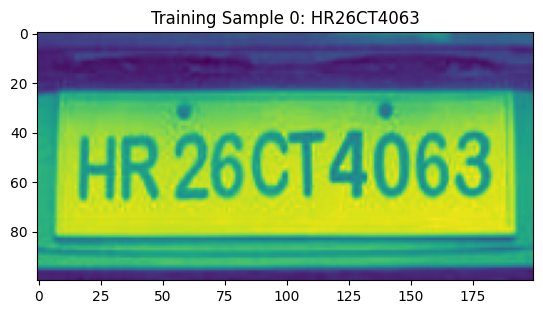

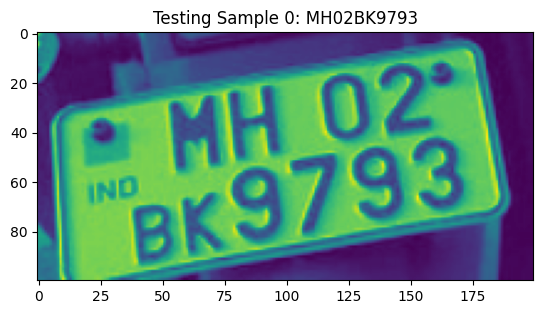

In [10]:
from matplotlib import pyplot as plt

opt = {'path': './dataset/LP-characters', 'imgdir': 'images'}
train_dataset = SynthDataset(opt, train=True)
test_dataset = SynthDataset(opt, train=False)

# Getting the first sample from the training and testing datasets
train_sample = train_dataset[5]
test_sample = test_dataset[5]

# Displaying the first training sample
plt.figure()
imshow(train_sample['img'], title=f"Training Sample 0: {train_sample['label']}")

# Displaying the first testing sample
plt.figure()
imshow(test_sample['img'], title=f"Testing Sample 0: {test_sample['label']}")


Checker function to see how the labels look like for debugging purposes, commented out due to its verbose output

In [22]:
'''import numpy as np

# Getting the total number of samples in the dataset
num_samples = len(train_dataset)

train_labels = []

# Iterating through the dataset 
for i in range(num_samples):
    sample = train_dataset[i]
    train_labels.append(sample['label'])

# Getting the unique labels and their counts
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))'''


"import numpy as np\n\n# Getting the total number of samples in the dataset\nnum_samples = len(train_dataset)\n\ntrain_labels = []\n\n# Iterating through the dataset \nfor i in range(num_samples):\n    sample = train_dataset[i]\n    train_labels.append(sample['label'])\n\n# Getting the unique labels and their counts\nunique, counts = np.unique(train_labels, return_counts=True)\nprint(dict(zip(unique, counts)))"

I have modified the model calling function as such:
Changed the arguments to reflect the new dataset path, the new checkpoint save location, the learn rate and the number of epochs, the last two being for obtaining the best possible performance out of the model.

Besides this I have also changed the alphabet variable, as the prior one was too comprehensive and better suited for general words, while license plates are more standardized, using only upper-case letters and numbers. Dashes are present in the `alphabet` string for the padding purposes later on in the evaluation function.

In [12]:
# Newly defined alphabet, better suited for the task
alphabet = """QWERTYUIOPASDFGHJKLZXCVBNM1234567890-"""

args = {
    'name':'exp1',
    'path':'dataset',
    'imgdir': 'train',
    'imgH':64,
    'nChannels':1,
    'nHidden':256,
    'nClasses':len(alphabet),
    # Experimented for a bit, the best results are with this lr and this amount of epochs
    'lr':0.0001,
    'epochs':130,
    'batch_size':32,
    'save_dir':'checkpoints_carplates',
    'log_dir':'logs_plates',
    'resume':False,
    'cuda':False,
    'schedule':False,
    
}

opt = {'path': './dataset/LP-characters', 'imgdir': 'images'}
train_dataset = SynthDataset(opt, train=True)
test_dataset = SynthDataset(opt, train=False)

args['collate_fn'] = SynthCollator()


args['data_train'], args['data_val'] = train_dataset, test_dataset
print('Traininig Data Size:{}\nVal Data Size:{}'.format(
    len(args['data_train']), len(args['data_val'])))
args['alphabet'] = alphabet
model = CRNN(args)


args['criterion'] = CustomCTCLoss()
savepath = os.path.join(args['save_dir'], args['name'])
gmkdir(savepath)
gmkdir(args['log_dir'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
learner = Learner(model, optimizer, savepath=savepath, resume=args['resume'])
learner.fit(args)


Traininig Data Size:167
Val Data Size:42


Epoch: [0]/[300] Training:   0%|          | 0/6 [00:00<?, ?it/s]

checkpoint does not exist
None
Scheduling is False


Validating: 100%|██████████| 2/2 [00:00<00:00,  7.26it/s, val_loss=15.6, val_ca=0, val_wa=0]   


16.22916889190674
Validation loss decreased (inf --> 16.229169).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s, val_loss=14.8, val_ca=0, val_wa=0]


15.812373161315918
Validation loss decreased (16.229169 --> 15.812373).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.81it/s, val_loss=11.5, val_ca=0, val_wa=0]


14.529131253560385
Validation loss decreased (15.812373 --> 14.529131).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.82it/s, val_loss=4.82, val_ca=0, val_wa=0]


12.144061803817749
Validation loss decreased (14.529131 --> 12.144062).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s, val_loss=3.63, val_ca=0, val_wa=0]


10.447014212608337
Validation loss decreased (12.144062 --> 10.447014).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=3.56, val_ca=0, val_wa=0]


9.309117078781128
Validation loss decreased (10.447014 --> 9.309117).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.77it/s, val_loss=3.74, val_ca=0, val_wa=0]


8.537924494062151
Validation loss decreased (9.309117 --> 8.537924).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.86it/s, val_loss=3.44, val_ca=0, val_wa=0]


7.90527680516243
Validation loss decreased (8.537924 --> 7.905277).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s, val_loss=3.41, val_ca=0, val_wa=0]


7.410354865921868
Validation loss decreased (7.905277 --> 7.410355).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.14it/s, val_loss=3.37, val_ca=0, val_wa=0]


7.011047601699829
Validation loss decreased (7.410355 --> 7.011048).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.58it/s, val_loss=3.37, val_ca=0, val_wa=0]


6.684042302044955
Validation loss decreased (7.011048 --> 6.684042).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s, val_loss=3.31, val_ca=0, val_wa=0]


6.404204577207565
Validation loss decreased (6.684042 --> 6.404205).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s, val_loss=3.26, val_ca=0, val_wa=0]


6.1644873435680685
Validation loss decreased (6.404205 --> 6.164487).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=3.23, val_ca=0, val_wa=0]


5.957105355603354
Validation loss decreased (6.164487 --> 5.957105).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s, val_loss=3.22, val_ca=0, val_wa=0]


5.776064538955689
Validation loss decreased (5.957105 --> 5.776065).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s, val_loss=3.2, val_ca=4.25, val_wa=0] 


5.616160556674004
Validation loss decreased (5.776065 --> 5.616161).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.52it/s, val_loss=3.18, val_ca=4.25, val_wa=0]


5.47390945518718
Validation loss decreased (5.616161 --> 5.473909).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s, val_loss=3.16, val_ca=4.25, val_wa=0]


5.346538292037116
Validation loss decreased (5.473909 --> 5.346538).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s, val_loss=3.16, val_ca=4, val_wa=0]   


5.2327227341501334
Validation loss decreased (5.346538 --> 5.232723).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s, val_loss=3.14, val_ca=6, val_wa=0]   


5.128507316112518
Validation loss decreased (5.232723 --> 5.128507).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.76it/s, val_loss=3.12, val_ca=6, val_wa=0]   


5.033457784425645
Validation loss decreased (5.128507 --> 5.033458).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s, val_loss=3.11, val_ca=6, val_wa=0]   


4.946205317974091
Validation loss decreased (5.033458 --> 4.946205).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s, val_loss=3.11, val_ca=5.11, val_wa=0]


4.867999403373055
Validation loss decreased (4.946205 --> 4.867999).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s, val_loss=3.06, val_ca=5.11, val_wa=0]


4.793449232975642
Validation loss decreased (4.867999 --> 4.793449).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.52it/s, val_loss=3.11, val_ca=6, val_wa=0]  


4.725959072113037
Validation loss decreased (4.793449 --> 4.725959).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.52it/s, val_loss=3.06, val_ca=5.11, val_wa=0]


4.662138434556814
Validation loss decreased (4.725959 --> 4.662138).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s, val_loss=3.1, val_ca=6, val_wa=0]    


4.603877420778628
Validation loss decreased (4.662138 --> 4.603877).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.83it/s, val_loss=3.03, val_ca=7.11, val_wa=0]


4.547654071024486
Validation loss decreased (4.603877 --> 4.547654).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.84it/s, val_loss=3.02, val_ca=6, val_wa=0]   


4.494990073401352
Validation loss decreased (4.547654 --> 4.494990).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=3.04, val_ca=5.11, val_wa=0]


4.446781106789907
Validation loss decreased (4.494990 --> 4.446781).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=3.02, val_ca=7.11, val_wa=0]


4.400799247526353
Validation loss decreased (4.446781 --> 4.400799).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s, val_loss=2.99, val_ca=7.11, val_wa=0]


4.356603652238846
Validation loss decreased (4.400799 --> 4.356604).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s, val_loss=2.99, val_ca=6.11, val_wa=0]


4.315172809543031
Validation loss decreased (4.356604 --> 4.315173).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=3.02, val_ca=6.22, val_wa=0]


4.277064709102406
Validation loss decreased (4.315173 --> 4.277065).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.55it/s, val_loss=3, val_ca=11.4, val_wa=0]   


4.2404922689710345
Validation loss decreased (4.277065 --> 4.240492).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.63it/s, val_loss=3.03, val_ca=12.5, val_wa=0]


4.206559790505303
Validation loss decreased (4.240492 --> 4.206560).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.54it/s, val_loss=3.01, val_ca=11.5, val_wa=0]


4.173941976315266
Validation loss decreased (4.206560 --> 4.173942).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.76it/s, val_loss=3.01, val_ca=12.5, val_wa=0]


4.143125966975563
Validation loss decreased (4.173942 --> 4.143126).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=2.96, val_ca=12.1, val_wa=0]


4.113094189228156
Validation loss decreased (4.143126 --> 4.113094).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s, val_loss=2.99, val_ca=10.8, val_wa=0]


4.085051083564759
Validation loss decreased (4.113094 --> 4.085051).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s, val_loss=2.98, val_ca=16.1, val_wa=0]


4.058132383881546
Validation loss decreased (4.085051 --> 4.058132).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s, val_loss=2.96, val_ca=9.47, val_wa=0]


4.032091001669566
Validation loss decreased (4.058132 --> 4.032091).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.53it/s, val_loss=3.03, val_ca=12.8, val_wa=0]


4.008416583371717
Validation loss decreased (4.032091 --> 4.008417).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s, val_loss=2.95, val_ca=12.8, val_wa=0]


3.9846631532365624
Validation loss decreased (4.008417 --> 3.984663).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=3.02, val_ca=11.8, val_wa=0]


3.963070895936754
Validation loss decreased (3.984663 --> 3.963071).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s, val_loss=2.99, val_ca=11.8, val_wa=0]


3.941837041274361
Validation loss decreased (3.963071 --> 3.941837).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s, val_loss=2.94, val_ca=12.6, val_wa=0]


3.9209241004700357
Validation loss decreased (3.941837 --> 3.920924).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.54it/s, val_loss=2.96, val_ca=9.83, val_wa=0]


3.901480940481027
Validation loss decreased (3.920924 --> 3.901481).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s, val_loss=2.97, val_ca=10.8, val_wa=0]


3.882504480225699
Validation loss decreased (3.901481 --> 3.882504).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s, val_loss=2.91, val_ca=10.8, val_wa=0]


3.8637056803703307
Validation loss decreased (3.882504 --> 3.863706).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.50it/s, val_loss=3, val_ca=11.8, val_wa=0] 


3.8471095211365642
Validation loss decreased (3.863706 --> 3.847110).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s, val_loss=2.99, val_ca=11.8, val_wa=0]


3.8305635498120236
Validation loss decreased (3.847110 --> 3.830564).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s, val_loss=2.96, val_ca=12.8, val_wa=0]


3.814562239736881
Validation loss decreased (3.830564 --> 3.814562).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s, val_loss=2.94, val_ca=12.7, val_wa=0]


3.7989401199199535
Validation loss decreased (3.814562 --> 3.798940).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.59it/s, val_loss=3.04, val_ca=11.8, val_wa=0]


3.7856040065938776
Validation loss decreased (3.798940 --> 3.785604).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s, val_loss=3, val_ca=11.8, val_wa=0]   


3.7714345221008574
Validation loss decreased (3.785604 --> 3.771435).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.59it/s, val_loss=2.99, val_ca=11.8, val_wa=0]


3.758037238790278
Validation loss decreased (3.771435 --> 3.758037).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.65it/s, val_loss=3.01, val_ca=8.83, val_wa=0]


3.7451492034155747
Validation loss decreased (3.758037 --> 3.745149).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.67it/s, val_loss=2.95, val_ca=12.8, val_wa=0]


3.7319225476960005
Validation loss decreased (3.745149 --> 3.731923).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s, val_loss=3.01, val_ca=12.8, val_wa=0]


3.7202194809913633
Validation loss decreased (3.731923 --> 3.720219).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s, val_loss=2.93, val_ca=10.8, val_wa=0]


3.707960023254645
Validation loss decreased (3.720219 --> 3.707960).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=2.98, val_ca=11.8, val_wa=0]


3.696279150824393
Validation loss decreased (3.707960 --> 3.696279).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.74it/s, val_loss=2.94, val_ca=12.8, val_wa=0]


3.6848338293650795
Validation loss decreased (3.696279 --> 3.684834).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s, val_loss=2.93, val_ca=13.1, val_wa=0]


3.67341729439795
Validation loss decreased (3.684834 --> 3.673417).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.68it/s, val_loss=2.97, val_ca=15.1, val_wa=0]


3.6631750932106604
Validation loss decreased (3.673417 --> 3.663175).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s, val_loss=3.05, val_ca=15.8, val_wa=0]


3.6545441529967566
Validation loss decreased (3.663175 --> 3.654544).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.63it/s, val_loss=2.95, val_ca=11.8, val_wa=0]


3.6441445386231837
Validation loss decreased (3.654544 --> 3.644145).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.52it/s, val_loss=2.96, val_ca=10.8, val_wa=0]


3.635142289540347
Validation loss decreased (3.644145 --> 3.635142).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.80it/s, val_loss=2.98, val_ca=8.83, val_wa=0]


3.626467015432275
Validation loss decreased (3.635142 --> 3.626467).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s, val_loss=2.99, val_ca=12.8, val_wa=0]


3.618442177772522
Validation loss decreased (3.626467 --> 3.618442).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s, val_loss=3.14, val_ca=8.74, val_wa=0]


3.6115534003351777
Validation loss decreased (3.618442 --> 3.611553).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.63it/s, val_loss=3.02, val_ca=10.1, val_wa=0]


3.6036775939994388
Validation loss decreased (3.611553 --> 3.603678).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.74it/s, val_loss=2.96, val_ca=13.1, val_wa=0]


3.5957952754138267
Validation loss decreased (3.603678 --> 3.595795).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.77it/s, val_loss=2.98, val_ca=11.1, val_wa=0]


3.5878356485753446
Validation loss decreased (3.595795 --> 3.587836).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.64it/s, val_loss=2.91, val_ca=14.8, val_wa=0]


3.579910012880961
Validation loss decreased (3.587836 --> 3.579910).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s, val_loss=2.99, val_ca=11.1, val_wa=0]


3.5726891944282935
Validation loss decreased (3.579910 --> 3.572689).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=2.95, val_ca=13.8, val_wa=0]


3.5652617339964037
Validation loss decreased (3.572689 --> 3.565262).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.65it/s, val_loss=2.99, val_ca=11.1, val_wa=0]


3.5582321897531166
Validation loss decreased (3.565262 --> 3.558232).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s, val_loss=3.06, val_ca=14.8, val_wa=0]


3.5526409722581693
Validation loss decreased (3.558232 --> 3.552641).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s, val_loss=3.03, val_ca=9.83, val_wa=0]


3.5460558101534843
Validation loss decreased (3.552641 --> 3.546056).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.80it/s, val_loss=3.07, val_ca=11.8, val_wa=0]


3.5402311027785878
Validation loss decreased (3.546056 --> 3.540231).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s, val_loss=3.02, val_ca=12.8, val_wa=0]


3.534065471916664
Validation loss decreased (3.540231 --> 3.534065).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.78it/s, val_loss=3.01, val_ca=12.1, val_wa=0]


3.5283126787966994
Validation loss decreased (3.534065 --> 3.528313).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.65it/s, val_loss=3.03, val_ca=10.7, val_wa=0]


3.522536229519617
Validation loss decreased (3.528313 --> 3.522536).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s, val_loss=3.1, val_ca=9.72, val_wa=0] 


3.517834016856025
Validation loss decreased (3.522536 --> 3.517834).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s, val_loss=2.96, val_ca=13.1, val_wa=0]


3.5119128241095434
Validation loss decreased (3.517834 --> 3.511913).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.67it/s, val_loss=3, val_ca=15.1, val_wa=0]   


3.506501349909552
Validation loss decreased (3.511913 --> 3.506501).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s, val_loss=3.03, val_ca=16.3, val_wa=0]


3.5016640831123698
Validation loss decreased (3.506501 --> 3.501664).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.76it/s, val_loss=3.14, val_ca=11.8, val_wa=0]


3.4975541106770547
Validation loss decreased (3.501664 --> 3.497554).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=3.03, val_ca=13.8, val_wa=0]


3.4924924585554336
Validation loss decreased (3.497554 --> 3.492492).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s, val_loss=2.96, val_ca=14.8, val_wa=0]


3.487165140581655
Validation loss decreased (3.492492 --> 3.487165).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.68it/s, val_loss=3.02, val_ca=15.1, val_wa=0]


3.482205525688503
Validation loss decreased (3.487165 --> 3.482206).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s, val_loss=3.01, val_ca=14.7, val_wa=0]


3.4776798281618344
Validation loss decreased (3.482206 --> 3.477680).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s, val_loss=3.05, val_ca=14.8, val_wa=0]


3.4736610486152326
Validation loss decreased (3.477680 --> 3.473661).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.65it/s, val_loss=2.99, val_ca=11.6, val_wa=0]


3.4692506137647126
Validation loss decreased (3.473661 --> 3.469251).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s, val_loss=3.09, val_ca=15.1, val_wa=0]


3.46595341215531
Validation loss decreased (3.469251 --> 3.465953).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s, val_loss=3.02, val_ca=14.8, val_wa=0]


3.461982723363896
Validation loss decreased (3.465953 --> 3.461983).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s, val_loss=3.07, val_ca=15.8, val_wa=0]


3.45858555302328
Validation loss decreased (3.461983 --> 3.458586).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s, val_loss=3.14, val_ca=12.1, val_wa=0]


3.455682766557944
Validation loss decreased (3.458586 --> 3.455683).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s, val_loss=3.14, val_ca=14.8, val_wa=0]


3.452780125141144
Validation loss decreased (3.455683 --> 3.452780).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s, val_loss=3, val_ca=14.1, val_wa=0]   


3.4494115303058437
Validation loss decreased (3.452780 --> 3.449412).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s, val_loss=3.09, val_ca=14.1, val_wa=0]


3.44629543318468
Validation loss decreased (3.449412 --> 3.446295).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.76it/s, val_loss=3.12, val_ca=11.5, val_wa=0]


3.443750213650824
Validation loss decreased (3.446295 --> 3.443750).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s, val_loss=3.08, val_ca=15.1, val_wa=0]


3.440473640194306
Validation loss decreased (3.443750 --> 3.440474).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s, val_loss=2.97, val_ca=15.1, val_wa=0]


3.4369878893806822
Validation loss decreased (3.440474 --> 3.436988).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s, val_loss=3.11, val_ca=13.8, val_wa=0]


3.4345262028136343
Validation loss decreased (3.436988 --> 3.434526).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.64it/s, val_loss=3.22, val_ca=12.7, val_wa=0]


3.4330629544837454
Validation loss decreased (3.434526 --> 3.433063).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s, val_loss=3.13, val_ca=15.8, val_wa=0]


3.430916557709376
Validation loss decreased (3.433063 --> 3.430917).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s, val_loss=3.18, val_ca=12.7, val_wa=0]


3.4291502401369427
Validation loss decreased (3.430917 --> 3.429150).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.68it/s, val_loss=3.16, val_ca=14.8, val_wa=0]


3.427250610698353
Validation loss decreased (3.429150 --> 3.427251).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s, val_loss=3.14, val_ca=13.9, val_wa=0]


3.4251410606745125
Validation loss decreased (3.427251 --> 3.425141).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s, val_loss=3.11, val_ca=14.8, val_wa=0]


3.4231204528893744
Validation loss decreased (3.425141 --> 3.423120).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=3.12, val_ca=11.6, val_wa=0]


3.42114105899777
Validation loss decreased (3.423120 --> 3.421141).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s, val_loss=3.07, val_ca=15.1, val_wa=0]   


3.4188935307034276
Validation loss decreased (3.421141 --> 3.418894).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s, val_loss=3.07, val_ca=16.3, val_wa=0]


3.4167790257412456
Validation loss decreased (3.418894 --> 3.416779).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s, val_loss=3.18, val_ca=15.8, val_wa=0]


3.415539455824885
Validation loss decreased (3.416779 --> 3.415539).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s, val_loss=3.14, val_ca=13.7, val_wa=0]


3.4141379920845356
Validation loss decreased (3.415539 --> 3.414138).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.55it/s, val_loss=3.2, val_ca=16.7, val_wa=0] 


3.412832227803893
Validation loss decreased (3.414138 --> 3.412832).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s, val_loss=3.21, val_ca=13.4, val_wa=0]


3.411638833895451
Validation loss decreased (3.412832 --> 3.411639).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s, val_loss=3.12, val_ca=18.3, val_wa=0]


3.41002499461174
Validation loss decreased (3.411639 --> 3.410025).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s, val_loss=3.15, val_ca=12.8, val_wa=0]


3.4089616852358353
Validation loss decreased (3.410025 --> 3.408962).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s, val_loss=3.16, val_ca=17, val_wa=0]  


3.4074278649736622
Validation loss decreased (3.408962 --> 3.407428).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s, val_loss=3.13, val_ca=14.8, val_wa=0]


3.4062202664894787
Validation loss decreased (3.407428 --> 3.406220).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.67it/s, val_loss=3.27, val_ca=14.8, val_wa=0]


3.405577854764077
Validation loss decreased (3.406220 --> 3.405578).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s, val_loss=3.19, val_ca=17.1, val_wa=0]


3.4046794023513796
Validation loss decreased (3.405578 --> 3.404679).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s, val_loss=3.18, val_ca=19.3, val_wa=0]


3.403833446048555
Validation loss decreased (3.404679 --> 3.403833).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s, val_loss=3.19, val_ca=16, val_wa=0]  


3.40343350594438
Validation loss decreased (3.403833 --> 3.403434).  Saving model ...


Epoch: [127]/[300] Training:  17%|█▋        | 1/6 [00:00<00:00,  5.95it/s, loss=0.785, train_ca=51.6, train_wa=0]

3.4034405909478664
EarlyStopping counter: (-3.403434 1 out of 15)


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.68it/s, val_loss=3.25, val_ca=17.9, val_wa=0]


3.403427927068962
Validation loss decreased (3.403434 --> 3.403428).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.52it/s, val_loss=3.23, val_ca=15.5, val_wa=0]


3.4026089017207806
Validation loss decreased (3.403428 --> 3.402609).  Saving model ...


Epoch: [130]/[300] Training:  17%|█▋        | 1/6 [00:00<00:00,  5.59it/s, loss=0.721, train_ca=55, train_wa=0]

3.4028355046992993
EarlyStopping counter: (-3.402609 1 out of 15)


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s, val_loss=3.17, val_ca=15.9, val_wa=0]


3.4020069160244684
Validation loss decreased (3.402609 --> 3.402007).  Saving model ...


Epoch: [132]/[300] Training:  17%|█▋        | 1/6 [00:00<00:00,  6.04it/s, loss=0.734, train_ca=54.2, train_wa=0]

3.4022395503252074
EarlyStopping counter: (-3.402007 1 out of 15)


Epoch: [133]/[300] Training:  17%|█▋        | 1/6 [00:00<00:00,  5.50it/s, loss=0.713, train_ca=53.1, train_wa=0]

3.4021796281658
EarlyStopping counter: (-3.402007 2 out of 15)


Epoch: [134]/[300] Training:  17%|█▋        | 1/6 [00:00<00:00,  5.96it/s, loss=0.645, train_ca=63.1, train_wa=0]

3.4025635957717895
EarlyStopping counter: (-3.402007 3 out of 15)


Epoch: [135]/[300] Training:  17%|█▋        | 1/6 [00:00<00:00,  5.69it/s, loss=0.69, train_ca=62, train_wa=0]

3.402270727297839
EarlyStopping counter: (-3.402007 4 out of 15)


Epoch: [136]/[300] Training:  17%|█▋        | 1/6 [00:00<00:00,  5.99it/s, loss=0.655, train_ca=60.5, train_wa=0]

3.4032229768098707
EarlyStopping counter: (-3.402007 5 out of 15)


Epoch: [137]/[300] Training:  17%|█▋        | 1/6 [00:00<00:00,  5.53it/s, loss=0.644, train_ca=61.4, train_wa=0]

3.4037726426470107
EarlyStopping counter: (-3.402007 6 out of 15)


Epoch: [138]/[300] Training:  17%|█▋        | 1/6 [00:00<00:00,  6.58it/s, loss=0.64, train_ca=61.6, train_wa=0.0312]

3.4038441318402186
EarlyStopping counter: (-3.402007 7 out of 15)


Epoch: [139]/[300] Training:  17%|█▋        | 1/6 [00:00<00:00,  5.34it/s, loss=0.632, train_ca=66.5, train_wa=0]

3.404572457926614
EarlyStopping counter: (-3.402007 8 out of 15)


Epoch: [140]/[300] Training:  17%|█▋        | 1/6 [00:00<00:00,  6.41it/s, loss=0.645, train_ca=64.7, train_wa=0]

3.404548409982776
EarlyStopping counter: (-3.402007 9 out of 15)


Epoch: [141]/[300] Training:   0%|          | 0/6 [00:00<?, ?it/s]

3.405907693883063
EarlyStopping counter: (-3.402007 10 out of 15)


Epoch: [142]/[300] Training:  17%|█▋        | 1/6 [00:00<00:00,  5.46it/s, loss=0.568, train_ca=70, train_wa=0.0312]

3.406188045348321
EarlyStopping counter: (-3.402007 11 out of 15)


Epoch: [143]/[300] Training:  17%|█▋        | 1/6 [00:00<00:00,  5.93it/s, loss=0.563, train_ca=68.3, train_wa=0.0312]

3.4060512582461038
EarlyStopping counter: (-3.402007 12 out of 15)


Epoch: [144]/[300] Training:   0%|          | 0/6 [00:00<?, ?it/s]

3.406742756942223
EarlyStopping counter: (-3.402007 13 out of 15)


Epoch: [145]/[300] Training:  17%|█▋        | 1/6 [00:00<00:00,  5.82it/s, loss=0.499, train_ca=75.4, train_wa=0.0625]

3.408506836793194
EarlyStopping counter: (-3.402007 14 out of 15)


Validating: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s, val_loss=3.37, val_ca=19.7, val_wa=0]

3.409331189531858
EarlyStopping counter: (-3.402007 15 out of 15)
Early stopping


After running the model for 127 epochs with a learning rate of 0.0001, it became apparent that the model was simply not converging to an acceptable loss value. I suspect that this poor performance may be due to its limited data size, as the total dataset is composed of just 209 images.

In [13]:
!nvidia-smi

Tue Oct 10 17:20:08 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98                 Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     Off | 00000000:03:00.0 Off |                  N/A |
|  0%   48C    P8              17W / 250W |    354MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [15]:
torch.cuda.empty_cache()

In [9]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [26]:
def get_accuracy(args, char_to_int):
    device = torch.device("cuda:2")
    loader = torch.utils.data.DataLoader(args['data'],
                batch_size=args['batch_size'],
                collate_fn=args['collate_fn'])
    model = args['model']
    model = model.to(device)  # Move the model to cuda:2
    model.eval()
    converter = OCRLabelConverter(args['alphabet'])
    evaluator = Eval()
    labels, predictions, images = [], [], []
    for iteration, batch in enumerate(tqdm(loader)):
        input_, targets = batch['img'].to(device), batch['label']
        images.extend(input_.squeeze().detach())
        labels.extend(targets)
        targets, lengths = converter.encode(targets)
        logits = model(input_).transpose(1, 0)
        logits = torch.nn.functional.log_softmax(logits, 2)
        logits = logits.contiguous().cpu()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
        predictions.extend(sim_preds)
        print(f'Batch {iteration + 1} Predictions: {sim_preds}')
        
#     make_grid(images[:10], nrow=2)
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        img = images[i]
        img = (img - img.min())/(img.max() - img.min())
        img = np.array(img.cpu() * 255.0, dtype=np.uint8)
        fig.add_subplot(rows, columns, i)
        plt.title(predictions[i])
        plt.axis('off')
        plt.imshow(img)
    plt.show()
    
    true_labels = []
    pred_labels = []

    for true_label, pred_label in zip(labels, predictions):
        true_chars = [char for char in true_label if char in char_to_int]
        pred_chars = [char for char in pred_label if char in char_to_int]

        # Finding the maximum length between the two sequences
        max_length = max(len(true_chars), len(pred_chars))

        # Padding the shorter sequence with a dash ('-')
        true_chars_padded = true_chars + ['-'] * (max_length - len(true_chars))
        pred_chars_padded = pred_chars + ['-'] * (max_length - len(pred_chars))

        # Converting characters to integers and appending to lists
        true_labels.append([char_to_int[char] for char in true_chars_padded])
        pred_labels.append([char_to_int[char] for char in pred_chars_padded])

    # Flattening the lists for compatibility with sklearn metrics
    flat_true_labels = [item for sublist in true_labels for item in sublist]
    flat_pred_labels = [item for sublist in pred_labels for item in sublist]

    accuracy = accuracy_score(flat_true_labels, flat_pred_labels)
    precision = precision_score(flat_true_labels, flat_pred_labels, average='weighted')
    recall = recall_score(flat_true_labels, flat_pred_labels, average='weighted')
    f1 = f1_score(flat_true_labels, flat_pred_labels, average='weighted')

    ca = np.mean((list(map(evaluator.char_accuracy, list(zip(predictions, labels))))))
    wa = np.mean((list(map(evaluator.word_accuracy_line, list(zip(predictions, labels))))))
    
    return ca, wa, accuracy, precision, recall, f1

Traininig Data Size:167
Val Data Size:42
Loading model checkpoints_carplates/exp1/best.ckpt


100%|██████████| 2/2 [00:00<00:00,  9.61it/s]

Batch 1 Predictions: ['T', 'MH2', 'TN0', 'TN9', 'HR27', 'KL0', 'H2', 'KL1', 'MH0', 'KR26', 'KL091', 'HR269', 'MH2', 'MA0', 'DL2', 'TN', 'T70', 'KL01', 'KH219', 'MH0', 'MH13', 'MH1', 'H2', 'MH', 'TN16', 'MH2', 'MH2', 'MH2', 'MH00', 'DP', 'HL2', 'TN24']
Batch 2 Predictions: ['MH20', 'MH13', 'MN34', 'TH2', 'MH0', 'TN03', 'MH210', 'H20', 'HR2', 'MH2']


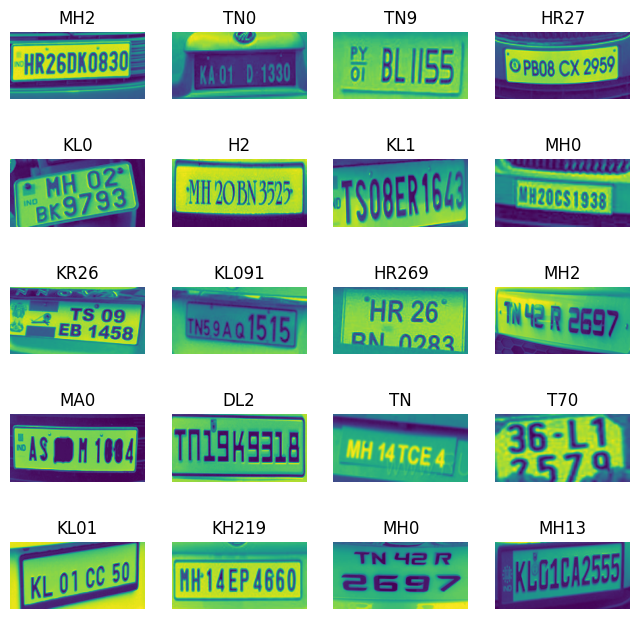

Character Accuracy: 15.64
Word Accuracy: 0.00
Accuracy: 0.10
Precision: 0.18
Recall: 0.10
F1 Score: 0.12


/home/guslasbo@GU.GU.SE/miniconda3/envs/Assignment1_ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
char_to_int = {char: idx for idx, char in enumerate(alphabet)}

args['imgdir'] = 'test'
args['data'] = test_dataset
resume_file = os.path.join(args['save_dir'], args['name'], 'best.ckpt')

if os.path.isfile(resume_file):
    print('Loading model %s' % resume_file)
    checkpoint = torch.load(resume_file)
    model.load_state_dict(checkpoint['state_dict'])
    args['model'] = model
    
    # Call the updated get_accuracy function
    ca, wa, accuracy, precision, recall, f1 = get_accuracy(args, char_to_int)
    
    # Print all the metrics
    print(f"Character Accuracy: {ca:.2f}")
    print(f"Word Accuracy: {wa:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
else:
    print("=> no checkpoint found at '{}'".format(save_file))
    print('Exiting')


Lastly, as we can see, the model's performance is indeed lacking. Not only is the model only able to detect at most 5 characters but even those are sometimes not even present in the image.

This can be seen from a qualitative analysis of the image grid, with the model predicted labels and the input images, where the model fails to properly recognize the characters, predicting only a limted amount of characters.

From a quantitative perspective, it can be noted that the model's Character Accuracy has an abysimal value of just 15.64, in other words, the model recognizes only 15.64% of the characters in a given image. That's not all, as the model's Word Accuracy is 0, which means that the model doesn't recognize any complete license plate number.

The sklearn accuracy score of 0.1 indicates that only 10% of the characters were accurately predicted (the difference from the Character Accuracy score can be attributed to the use of label padding)

The precision score of 0.18 means that only 18% of the positive identifications were actually correct. This low score also signals a low peforming model.

The recall score reflects the model's poor performance, as it means that the model identified only 10% of all actual positive cases (matching characters).

Lastly, the F1 score of 0.12 shows that the model does not have a balanced precision and recal score and that it is also performing poorly.

Possible reasons for the models performance may be the image's size in the dataset, perhaps using a larger image would work, despite the impact to the VRAM memory. 
Another hypothesis I have is that the model could be improved by using a larger dataset, possibly 2000 images or more.
An idea on how to improve the model with the existing data would be to train a model on predicted individual characters and then use transfer learning to apply it to this sequence of character recognizer model. The initial model could be trained by utilizing the areas of each specific character have been delimited in the .XML files. This way, the model could be trained in a semi-supervised way on little more than 2000 characters in total.
Lastly, a practical idea would be changing the model's architecture directly, by adding more layers such as 